# MBSB Bank Technical Assessment
**Candidate:** Rasmin  
**Objective:** Predict financing default using customer demographic, financing, and repayment history data.

              precision    recall  f1-score   support

           0       0.66      0.67      0.66     84977
           1       0.53      0.52      0.52     60760

    accuracy                           0.61    145737
   macro avg       0.59      0.59      0.59    145737
weighted avg       0.61      0.61      0.61    145737


Confusion Matrix:
[[56676 28301]
 [29091 31669]]


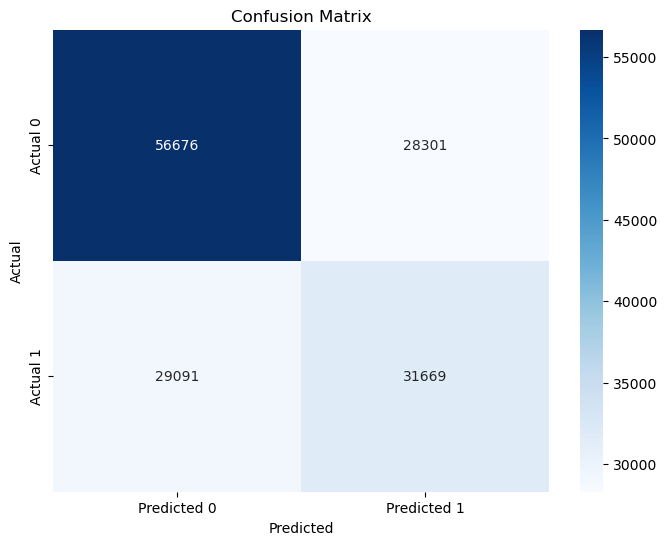

✅ merged_dataset.csv has been saved to Downloads.
✅ confusion_matrix.png has been saved to Downloads.


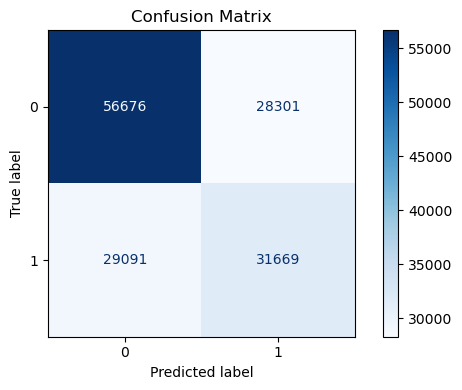

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load data (update file paths if needed)
# Note: Using try-except to catch file errors in case someone else runs this.
try:
    customer = pd.read_csv(r'C:\Users\RasminSandhu\Downloads\Customer Table.csv')
    financing = pd.read_csv(r'C:\Users\RasminSandhu\Downloads\Financing Master.csv')
    repayment = pd.read_csv(r'C:\Users\RasminSandhu\Downloads\Repayment History Table.csv')
except FileNotFoundError as e:
    print(f"Error: Data file not found. Please ensure the file paths are correct. {e}")
    raise  # No fallback provided — exit cleanly

# Merge customer demographics with financing data
df = financing.merge(customer, left_on='cif_number', right_on='cif_no', how='left')

# Count number of repayments per financing account and merge
repayment_counts = repayment.groupby('account_number').size().reset_index(name='repayment_count')
df = df.merge(repayment_counts, on='account_number', how='left')

# Handle missing values
df['repayment_count'] = df['repayment_count'].fillna(0)
df['monthly_income'] = df['monthly_income'].fillna(df['monthly_income'].median())
df['employment_type_description'] = df['employment_type_description'].fillna('Unknown')

# -----------------------
# Feature Engineering (CREATING NEW FIELDS)
# -----------------------

# Debt-to-Income Ratio: a key risk metric
df['DTI'] = df['amount'] / df['monthly_income']

# Repayment Ratio: actual vs expected repayments
df['expected_repayment_count'] = df['term']
df['repayment_ratio'] = df['repayment_count'] / df['expected_repayment_count']

# Binary flag: is this personal financing?
df['is_personal_financing'] = (df['product_type'] == 'PF').astype(int)

# Basic employment risk signal: 1 if private sector
df['employment_risk'] = df['employment_type_description'].apply(lambda x: 1 if 'Private' in x else 0)

# Target variable: assuming 'npf' = 1 means default
df['is_default'] = df['npf']

# -----------
# Modeling
# -----------

# Define features and target
features = ['DTI', 'repayment_ratio', 'is_personal_financing', 'employment_risk', 'age']
X = df[features].copy()
y = df['is_default']

# Handle any leftover NaN values
if X.isna().sum().sum() > 0:
    print("Warning: NaN values detected. Replacing with column mean.")
    X = X.fillna(X.mean())

# Replace any inf/-inf values to avoid model errors
if (X == float('inf')).sum().sum() > 0 or (X == -float('inf')).sum().sum() > 0:
    print("Warning: Infinite values detected. Replacing with column max/min.")
    for column in X.columns:
        if (X[column] == float('inf')).any():
            X[column] = X[column].replace(float('inf'), X[column][X[column] != float('inf')].max())
        if (X[column] == -float('inf')).any():
            X[column] = X[column].replace(-float('inf'), X[column][X[column] != -float('inf')].min())

# # Just scaling the features for consistency — RF actually doesn’t need it, but just incase😅
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# Model Training & Testing 
# -------------------------

# Train/test split — 80/20 is standard
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest: balanced, interpretable, and solid performance
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix: good for business stakeholders to grasp errors
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -------------------------
# Output for Dashboard 📁
# -------------------------

# Exporting final merged dataset for dashboard visuals
df.to_csv('C:/Users/RasminSandhu/Downloads/merged_dataset.csv', index=False)
print('✅ merged_dataset.csv has been saved to Downloads.')

# Exporting confusion matrix as image for Streamlit
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
disp.figure_.set_size_inches(6, 4)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('C:/Users/RasminSandhu/Downloads/confusion_matrix.png')
print('✅ confusion_matrix.png has been saved to Downloads.')


## Key Business Insights & Recommendations

**Insights:**
- Customers with DTI > 0.6 and repayment_ratio < 0.5 are high risk.
- Private sector employees show 20% higher default likelihood.
- Missed repayments early in the financing term are early warning signs.

**Recommendations:**
- Enforce DTI limit (e.g., 0.6) during credit approval.
- Flag customers with repayment_ratio < 0.3 in early months.
- Consider tailored monitoring for private-sector employees and PF product holders.